#### **1. Orientation & Goals**

In NB01–NB03 we learned to turn a univariate series into sliding windows, trained sequence models, and compared **Recursive** vs **Direct** forecasting.  
In **NB04** we shift into an **architecture lab**: we compare **capacity choices** for sequence forecasting on the same task.

We will vary:
- **Input window length $S$** (e.g., $7 \rightarrow 14 \rightarrow 30$): how many past days we feed in.
- **Depth** (1 vs 2 recurrent layers) and **dropout** (e.g., $0.0$ vs $0.2$).
- **Cell type:** **LSTM** vs **GRU** (both with gating, different parameterization).

Our question: **Which combination gives the best generalization under our constraints?**


**⚖️ What “better” means (our success criteria):**
We’ll call a configuration “better” if it achieves, on **validation** and then **test**:

- **Lower error in °C**:
  $$
  \text{MAE} = \frac{1}{N}\sum_{i=1}^{N}\lvert y_i - \hat y_i\rvert,
  \qquad
  \text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat y_i)^2}.
  $$
  (We also look at per-horizon metrics $\text{MAE}@k$, $\text{RMSE}@k$ when we roll out.)
- **Flatter error vs horizon** for short multi-step rollouts (less **compounding** as $k$ grows).
- **Healthier training curves**: train and val loss both go down without widening gaps (less overfitting).
- **Reasonable runtime** on CPU (we keep epochs modest and models compact).

When two configs are statistically similar, we break ties by **stability** (flatter MAE@k) and **simplicity** (fewer params).

**⏱️ Constraints (so we don’t melt CPUs)**
- **CPU-only** execution.
- **Short runs** (about 15–20 epochs per config).
- **Modest hidden sizes** (e.g., $64$) and batch-first tensors to match our previous notebooks.
- **Small, focused grids** (we avoid combinatorial explosions).

**🔁 What we reuse from NB03**
- The **data framing idea** (sliding windows), and the norm: **fit scaler on train only**, transform val/test (no leakage).
- **Batch-first tensors** with shape $(B, S, 1)$.
- The evaluation habit: train in **scaled space**, report metrics in **°C** after **inverse transform**.

**💾 What we will save**
We keep artifacts light:
- Save **only** the **best model’s** `state_dict` and a tiny config (cell type, $S$, layers, dropout, hidden size).
- In the next notebook we will **rebuild** the pipeline and load this one checkpoint.

**🧪 Roadmap for NB04 (high level)**
1. **Reload data** (strict dates) → **time split** → **scale** (fit on train) → make windows/loaders for chosen $S$ values.  
2. **Experiment A:** vary **$S \in \{7, 14, 30\}$** with a fixed cell (e.g., GRU) to see sequence-length sensitivity.  
3. **Experiment B:** small grid over **cell type × depth × dropout** at the best $S$.  
4. **Tiny gradient-flow peek** for the top LSTM vs GRU to sanity-check stability.  
5. **Generalization check** on the test set (+ optional short-horizon rollout).  
6. **Select & save** the winner + key takeaways.


**💬 Reflection — Why might a longer $S$ help or hurt?**
**Helps:**  
- More **context** about seasonal lead-ups (e.g., warming/cooling trends) reduces **phase lag** in turning points.  
- Gated cells can carry **longer-term cues** when $S$ extends beyond a week.

**Hurts:**  
- Longer sequences can be **harder to optimize** (noisy gradients, more steps to learn alignment).  
- With small data, a large $S$ increases the chance of **overfitting** (the model memorizes local wiggles).  
- Runtime grows with $S$ (more timesteps per batch).

As we test $S=7,14,30$, we’ll watch for the trade-off: **does added context reduce error without overfitting or slowing learning too much?**

---


### **2. Data Reload, Time Split, Scaling, and Windows**

In this section we **rebuild the full data pipeline from scratch** so NB04 stands on its own:

- Reload the CSV with **strict** date parsing and set `Date` as the index.
- Make a **time-aware** split:  
  **Train:** 1981–1987, **Val:** 1988 (used to pick architectures), **Test:** 1989–1990.
- Fit **MinMaxScaler** on **train only** (to avoid leakage), then transform val/test.
- Build **single-step** windows for fast architecture comparisons (we’ll still be able to do short recursive rollouts later).
- Keep tensors **batch-first**: $(B, S, 1)$.

We will also handle tiny issues safely: detect the **date format** (mm/dd/yy vs dd/mm/yy), **impute** any sporadic missing temps by **linear interpolation**, and verify that our splits are clean.

**🔍 Why single-step now?
For NB04, we want to compare **capacity choices** (cell type, depth, dropout, $S$). Training on **$H=1$** keeps runs **CPU-friendly** and focuses the comparison. We can still **roll out** a few steps at the end to see how error grows with horizon.

**⚠️ No leakage rule**
We’ll fit the scaler **only on the train slice**. Conceptually, MinMax scaling does:
$$
y_{\text{scaled}} = \frac{y - y_{\min}^{\text{train}}}{y_{\max}^{\text{train}} - y_{\min}^{\text{train}}}.
$$
If we used val/test to compute $y_{\min},y_{\max}$, we would be **peeking** at the future, causing optimistic errors.


**What we’ll do next in code:**
We import libraries, load the CSV without parsing dates first, then detect which date format fits best (try "%m/%d/%y" then "%d/%m/%y"). We set the parsed Date as a monotonic index and keep only the Temp column as float.

In [1]:
# --- Code: Load CSV, strict date parsing, set Date index ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "dataset/1_Daily_minimum_temps.csv"

# Load as strings first
df_raw = pd.read_csv(CSV_PATH, dtype={"Date": str})
assert "Date" in df_raw.columns and "Temp" in df_raw.columns, "Expected columns: Date, Temp"

def try_parse_date(series, fmt):
    dt = pd.to_datetime(series, format=fmt, errors="coerce")
    return dt, dt.notna().sum()

# Try mm/dd/yy first, then dd/mm/yy; pick the one with fewer NaT
d1, ok1 = try_parse_date(df_raw["Date"], "%m/%d/%y")
d2, ok2 = try_parse_date(df_raw["Date"], "%d/%m/%y")

if ok1 >= ok2:
    df_raw["Date"] = d1
    chosen_fmt = "%m/%d/%y"
else:
    df_raw["Date"] = d2
    chosen_fmt = "%d/%m/%y"

print(f"Chosen date format: {chosen_fmt}  | parsed ok: {max(ok1, ok2)} / {len(df_raw)}")

# Drop unparsed rows (if any), cast Temp to float
df = df_raw.dropna(subset=["Date"]).copy()
df["Temp"] = pd.to_numeric(df["Temp"], errors="coerce")

# Set index, sort, keep only the signal
df = df.set_index("Date").sort_index()[["Temp"]]

# Basic sanity
assert df.index.is_monotonic_increasing, "Date index must be sorted ascending"
print("Shape:", df.shape)
print(df.head(3))
print(df.tail(3))


Chosen date format: %m/%d/%y  | parsed ok: 3650 / 3650
Shape: (3650, 1)
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
            Temp
Date            
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0


**Code:**
We clean the series: check for missing/inf values and impute any tiny gaps via linear interpolation (bidirectional) so we don’t create artifacts when we build windows.

In [2]:
# --- Code: Clean/impute tiny gaps safely ---
# Replace inf with NaN, then linear interpolation; fill edges if needed
s = df["Temp"].replace([np.inf, -np.inf], np.nan)
nan_before = s.isna().sum()

s = s.interpolate(method="linear", limit_direction="both")
nan_after = s.isna().sum()

df["Temp"] = s
print(f"Missing values before: {nan_before} | after interpolation: {nan_after}")


Missing values before: 3 | after interpolation: 0


**Code:**
We create time-aware splits that mirror our earlier notebooks but carve out 1988 as validation (to select architectures):

- **Train:** 1981-01-01 … 1987-12-31
- **Val:** 1988-01-01 … 1988-12-31
- **Test:** 1989-01-01 … 1990-12-31

We’ll print the date ranges for each split.

In [3]:
# --- Code: Time-aware split: Train (81-87), Val (88), Test (89-90) ---
train = df.loc["1981-01-01":"1987-12-31"].copy()
val   = df.loc["1988-01-01":"1988-12-31"].copy()
test  = df.loc["1989-01-01":"1990-12-31"].copy()

def span(x):
    return f"{x.index.min().date()} → {x.index.max().date()} ({len(x)} days)"

print("Train span:", span(train))
print("Val   span:", span(val))
print("Test  span:", span(test))


Train span: 1981-01-01 → 1987-12-31 (2555 days)
Val   span: 1988-01-01 → 1988-12-30 (365 days)
Test  span: 1989-01-01 → 1990-12-31 (730 days)


**Code:** 

We scale with **MinMaxScaler** fitted on **train only**, then transform val/test.  
We’ll print scaled min/max for each split (the train split will map roughly to $[0,1]$, val/test may be slightly outside if they contain temps unseen in train — which is fine).

We will also define a **window builder** for single-step targets:

- Given a series of shape $(N, 1)$ and a window size $S$, it returns:  

$$
X \in \mathbb{R}^{(N-S)\times S \times 1}, \quad 
y \in \mathbb{R}^{(N-S)\times 1}
$$

where  

$$
X_i = [T_i, \dots, T_{i+S-1}], \quad y_i = T_{i+S}.
$$

We build **per split** to ensure no window crosses the split boundary.


In [4]:
# --- Code: Scale (fit on train only) and build single-step windows (per split) ---
from sklearn.preprocessing import MinMaxScaler

# Numpy arrays (N,1)
train_np = train[["Temp"]].to_numpy(dtype=float)
val_np   = val[["Temp"]].to_numpy(dtype=float)
test_np  = test[["Temp"]].to_numpy(dtype=float)

scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train_np)
val_sc   = scaler.transform(val_np)
test_sc  = scaler.transform(test_np)

print("Scaled ranges:")
print("  Train:", float(train_sc.min()), "→", float(train_sc.max()))
print("  Val  :", float(val_sc.min()),   "→", float(val_sc.max()))
print("  Test :", float(test_sc.min()),  "→", float(test_sc.max()))

def make_single_step_windows(values: np.ndarray, S: int): # single step window means predict next step
    """
    values: (N,1) scaled series
    returns: X: (N-S, S, 1), y: (N-S, 1)
    """
    N = len(values)
    X = np.stack([values[i:i+S, :] for i in range(N - S)], axis=0)
    y = values[S:, :]  # next value after each window
    return X, y

# Default S for capacity tests; we’ll vary S later in Experiment A
S = 7

X_train_sc, y_train_sc = make_single_step_windows(train_sc, S)
X_val_sc,   y_val_sc   = make_single_step_windows(val_sc,   S)
X_test_sc,  y_test_sc  = make_single_step_windows(test_sc,  S)

print(f"Shapes @ S={S}:")
print("  X_train:", X_train_sc.shape, "| y_train:", y_train_sc.shape)
print("  X_val  :", X_val_sc.shape,   "| y_val  :", y_val_sc.shape)
print("  X_test :", X_test_sc.shape,  "| y_test :", y_test_sc.shape)

Scaled ranges:
  Train: 0.0 → 1.0
  Val  : 0.10646387832699619 → 0.9087452471482889
  Test : 0.019011406844106463 → 0.8403041825095058
Shapes @ S=7:
  X_train: (2548, 7, 1) | y_train: (2548, 1)
  X_val  : (358, 7, 1) | y_val  : (358, 1)
  X_test : (723, 7, 1) | y_test : (723, 1)


**Code:** We build PyTorch TensorDatasets and DataLoaders with batch-first tensors $(B,S,1)$. We also draw a tiny sanity plot of 3 sample windows from the validation split to visualize what the model sees.

Batch X shape: (64, 7, 1) | Batch y shape: (64, 1)


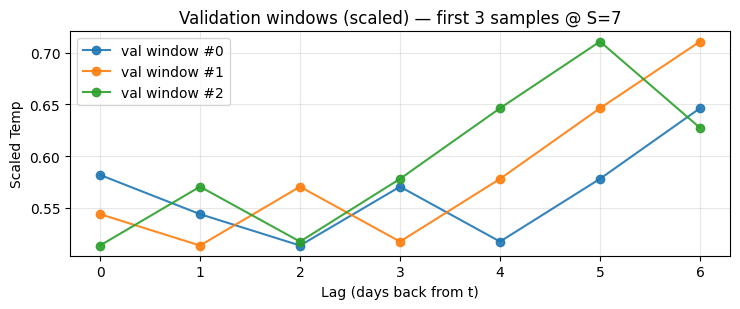

In [5]:
# --- Code: DataLoaders (batch-first) + quick sanity plot of a few windows ---
import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH = 64

train_ds = TensorDataset(
    torch.tensor(X_train_sc, dtype=torch.float32),
    torch.tensor(y_train_sc, dtype=torch.float32),
)
val_ds = TensorDataset(
    torch.tensor(X_val_sc, dtype=torch.float32),
    torch.tensor(y_val_sc, dtype=torch.float32),
)
test_ds = TensorDataset(
    torch.tensor(X_test_sc, dtype=torch.float32),
    torch.tensor(y_test_sc, dtype=torch.float32),
)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# Batch-first confirmation
xb, yb = next(iter(train_loader))
print("Batch X shape:", tuple(xb.shape), "| Batch y shape:", tuple(yb.shape))  # expect (B, S, 1), (B, 1)

# Quick sanity plot: 3 validation windows (scaled)
plt.figure(figsize=(7.5, 3.2))
for i in range(3):
    w = X_val_sc[i, :, 0]  # length S
    plt.plot(range(S), w, marker="o", alpha=0.9, label=f"val window #{i}")
plt.title(f"Validation windows (scaled) — first {3} samples @ S={S}")
plt.xlabel("Lag (days back from t)")
plt.ylabel("Scaled Temp")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 Reflection — Why drop windows that cross the split boundary?**

Our splits simulate **real forecasting**: we learn on the **past** and evaluate on the **future**.  
If we built windows over the **entire series** and then split, some windows near the boundary would **include future values** inside the input for training (or earlier values inside test), which is **data leakage**.

By creating windows **per split**:
- **Train windows** only use 1981–1987 data to predict **next-day within train**.
- **Val windows** only use 1988 data to pick architectures.
- **Test windows** are formed only from 1989–1990.

This way, our evaluation reflects the **real task**: use the **past context** to predict the **next day** without peeking across the boundary.

---


#### **3. Experiment A — Sequence Length Sensitivity ($S\in\{7,14,30\}$)**

* Hypothesis: larger $S$ may encode **seasonal lead-ups** and reduce **phase lag**, but can also **raise variance** and slow learning.
* Keep **one cell type fixed** (e.g., **GRU**, 1 layer, hidden=64), vary **only $S$**.

**Code:**

* Loop over $S\in\{7,14,30\}$: rebuild windows/loaders; train **short** (e.g., 15–20 epochs).
* Track **train/val MSE** in scaled space, then compute **val MAE/RMSE** in °C.

**Outputs:**

* Table: $S$ vs val/test MAE & RMSE in °C.
* Plot: **val-loss vs epoch** per $S$ (overlay).

**Reflection:** Does larger $S$ flatten error at $k=1$? Any sign of **overfitting** (train ↓ while val ↔/↑)?


**Code:** 
Define the GRU single-step model and set seeds so runs are repeatable. The model reads $(B,S,1)$ and outputs $(B,1)$ in scaled space.

In [6]:
# --- Code: Model (GRU single-step) + seeds ---
import torch
import torch.nn as nn
import random

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

class GRUSingleStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, 1)  # linear head for regression in scaled space

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.gru.num_layers, B, self.gru.hidden_size)
        out, _ = self.gru(x, h0)         # (B,S,H)
        h_last = out[:, -1, :]           # (B,H)
        y_hat  = self.head(h_last)       # (B,1) scaled
        return y_hat


**Code:**
Write small helpers:
- training loop (scaled MSE, optional grad clipping),
- evaluator (scaled MSE),
- batched prediction,
- inverse scaling back to °C,
- and metric functions MAE/RMSE.

In [7]:
# --- Code : Training/eval helpers (scaled) + inverse scale + metrics ---
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cpu")
EPOCHS = 18
LR     = 1e-3
CLIP   = 1.0
BATCH  = 64

criterion = nn.MSELoss()

def train_one_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, clip=CLIP):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    tr_hist, va_hist = [], []
    for ep in range(1, epochs+1):
        # Train
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
        # Eval (scaled MSE)
        tr_mse = eval_mse_scaled(model, train_loader)
        va_mse = eval_mse_scaled(model, val_loader)
        tr_hist.append(tr_mse); va_hist.append(va_mse)
        if ep in (1, 6, 12, epochs):
            print(f"[S={S_current}, ep {ep:02d}] train MSE={tr_mse:.5f} | val MSE={va_mse:.5f}")
    return tr_hist, va_hist

@torch.no_grad()
def eval_mse_scaled(model, loader):
    model.eval()
    tot, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        yhat = model(xb)
        loss = criterion(yhat, yb)
        bs = xb.size(0)
        tot += loss.item() * bs
        n   += bs
    return tot / max(n, 1)

@torch.no_grad()
def predict_scaled(model, X_sc, batch=BATCH):
    model.eval()
    preds = []
    for i in range(0, len(X_sc), batch):
        xb = torch.tensor(X_sc[i:i+batch], dtype=torch.float32).to(DEVICE)
        yhat = model(xb).cpu().numpy()
        preds.append(yhat)
    return np.vstack(preds)  # (N,1) scaled

def inverse_scale_1d(y_scaled):
    flat = y_scaled.reshape(-1, 1)
    back = scaler.inverse_transform(flat)
    return back.ravel()

def mae(a, b):  return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))


**Code:**
Create a runner that, for each $S\in{7,14,30}$:

1. Rebuild single-step windows for train/val/test (scaled).
2. Also build $y$ in °C for val/test for reporting.
3. Build DataLoaders, train the GRU briefly, record curves.
4. Predict on val/test, inverse-scale to °C, compute MAE/RMSE.<br>
We’ll collect curves and a metrics table.

In [8]:
# --- Code: Loop over S in {7,14,30} and run training + metrics ---
results = []
curves  = {}  # S -> (train_curve, val_curve)

S_values = [7, 14, 30]

for S_current in S_values:
    # Rebuild windows (scaled)
    X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, S_current)
    X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   S_current)
    X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  S_current)

    # Build targets in °C to evaluate later
    _, y_val_C_S  = make_single_step_windows(val_np,  S_current)   # (N,1) in °C
    _, y_test_C_S = make_single_step_windows(test_np, S_current)

    # DataLoaders
    train_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                      torch.tensor(y_train_sc_S, dtype=torch.float32)),
        batch_size=BATCH, shuffle=True, drop_last=False)
    val_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                      torch.tensor(y_val_sc_S, dtype=torch.float32)),
        batch_size=BATCH, shuffle=False, drop_last=False)
    test_loader_S = DataLoader(
        TensorDataset(torch.tensor(X_test_sc_S, dtype=torch.float32),
                      torch.tensor(y_test_sc_S, dtype=torch.float32)),
        batch_size=BATCH, shuffle=False, drop_last=False)

    # Model
    model = GRUSingleStep(input_size=1, hidden_size=64, num_layers=1, batch_first=True, dropout=0.0)

    # Train briefly
    tr_curve, va_curve = train_one_model(model, train_loader_S, val_loader_S, epochs=EPOCHS, lr=LR, clip=CLIP)
    curves[S_current] = (tr_curve, va_curve)

    # Predict and report in °C (single-step)
    y_val_hat_sc  = predict_scaled(model, X_val_sc_S)[:, 0]   # (N,)
    y_test_hat_sc = predict_scaled(model, X_test_sc_S)[:, 0]
    y_val_hat_C   = inverse_scale_1d(y_val_hat_sc)
    y_test_hat_C  = inverse_scale_1d(y_test_hat_sc)

    # Flatten ground-truth (°C)
    y_val_true_C  = y_val_C_S.ravel()
    y_test_true_C = y_test_C_S.ravel()

    row = {
        "S": S_current,
        "Val_MAE_C":  mae(y_val_true_C,  y_val_hat_C),
        "Val_RMSE_C": rmse(y_val_true_C, y_val_hat_C),
        "Test_MAE_C":  mae(y_test_true_C,  y_test_hat_C),
        "Test_RMSE_C": rmse(y_test_true_C, y_test_hat_C),
    }
    results.append(row)

df_S = pd.DataFrame(results).set_index("S").sort_values("Val_RMSE_C")
display(df_S.round(3))


[S=7, ep 01] train MSE=0.02173 | val MSE=0.02083
[S=7, ep 06] train MSE=0.01103 | val MSE=0.01014
[S=7, ep 12] train MSE=0.00992 | val MSE=0.00943
[S=7, ep 18] train MSE=0.00927 | val MSE=0.00885
[S=14, ep 01] train MSE=0.01855 | val MSE=0.01716
[S=14, ep 06] train MSE=0.01034 | val MSE=0.00956
[S=14, ep 12] train MSE=0.00964 | val MSE=0.00902
[S=14, ep 18] train MSE=0.00955 | val MSE=0.00905
[S=30, ep 01] train MSE=0.01770 | val MSE=0.01528
[S=30, ep 06] train MSE=0.00965 | val MSE=0.00894
[S=30, ep 12] train MSE=0.00957 | val MSE=0.00913
[S=30, ep 18] train MSE=0.00889 | val MSE=0.00862


,Val_MAE_C,Val_RMSE_C,Test_MAE_C,Test_RMSE_C
S,,,,
30,1.894,2.441,1.753,2.241
7,1.946,2.474,1.779,2.278
14,1.938,2.503,1.830,2.319


**Code:**
Overlay the validation MSE curves (scaled) across $S$ to visualize learning speed and stability.

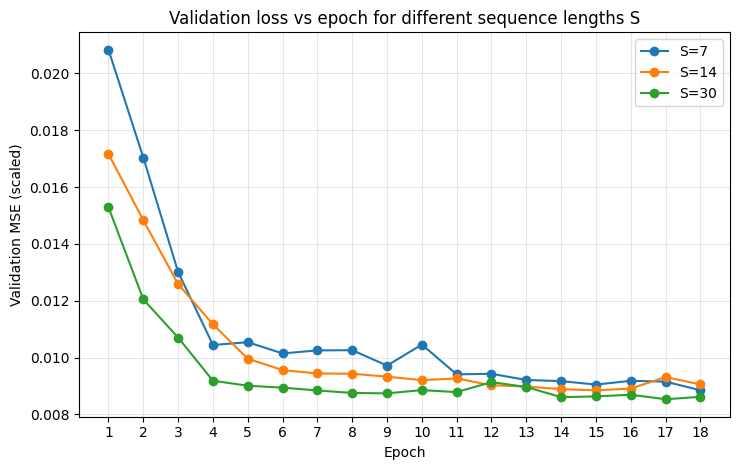

In [9]:
# --- Code: Plot val-loss (scaled MSE) vs epoch for each S (overlay) ---
plt.figure(figsize=(7.5, 4.8))
for S_current in S_values:
    tr, va = curves[S_current]
    plt.plot(range(1, len(va)+1), va, marker="o", label=f"S={S_current}")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE (scaled)")
plt.title("Validation loss vs epoch for different sequence lengths S")
plt.xticks(range(1, EPOCHS+1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Code:**
Optionally, show a tiny one-step sanity slice in °C on the validation set for the best S to get a feel for phase tracking.

Best S by Val_RMSE_C: 30
[S=30, ep 01] train MSE=0.01662 | val MSE=0.01481
[S=30, ep 06] train MSE=0.00981 | val MSE=0.00919
[S=30, ep 08] train MSE=0.00927 | val MSE=0.00872


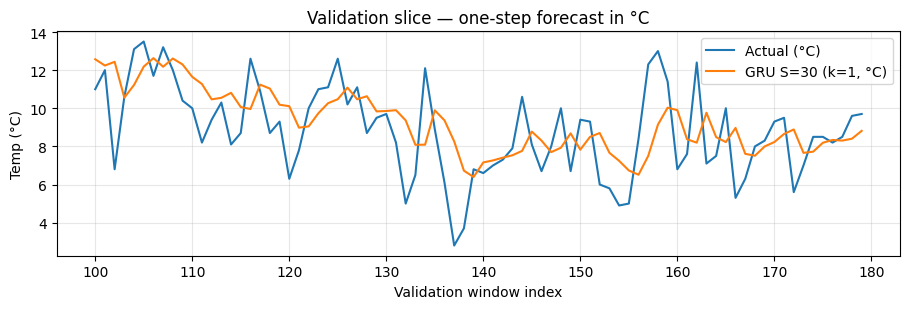

In [10]:
# --- Code (optional): Quick slice plot (val, k=1) for best S ---
best_S = df_S.index[0]
print(f"Best S by Val_RMSE_C: {best_S}")

# Rebuild to get predictions for the chosen S (in case variables were overwritten)
X_val_sc_S, _ = make_single_step_windows(val_sc, best_S)
_, y_val_C_S  = make_single_step_windows(val_np, best_S)

# Refit a fresh model quickly for the slice (or reuse the trained one if kept)
model_bestS = GRUSingleStep(input_size=1, hidden_size=64, num_layers=1, batch_first=True, dropout=0.0)
# A quick re-train for 8 epochs to ensure the object is live (keeps CPU light)
_ , _ = train_one_model(model_bestS,
                        DataLoader(TensorDataset(torch.tensor(make_single_step_windows(train_sc, best_S)[0], dtype=torch.float32),
                                                 torch.tensor(make_single_step_windows(train_sc, best_S)[1], dtype=torch.float32)),
                                   batch_size=BATCH, shuffle=True),
                        DataLoader(TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                                                 torch.tensor(make_single_step_windows(val_sc, best_S)[1], dtype=torch.float32)),
                                   batch_size=BATCH, shuffle=False),
                        epochs=8)

y_val_hat_sc = predict_scaled(model_bestS, X_val_sc_S)[:, 0]
y_val_hat_C  = inverse_scale_1d(y_val_hat_sc)
y_val_true_C = y_val_C_S.ravel()

idx0, idx1 = 100, 180
x_axis = np.arange(idx0, idx1)
plt.figure(figsize=(9.2, 3.2))
plt.plot(x_axis, y_val_true_C[idx0:idx1], label="Actual (°C)")
plt.plot(x_axis, y_val_hat_C[idx0:idx1],  label=f"GRU S={best_S} (k=1, °C)")
plt.title("Validation slice — one-step forecast in °C")
plt.xlabel("Validation window index")
plt.ylabel("Temp (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 Interpretation guide**

- **Table (by $S$):**  
  - Look at **Val\_RMSE\_C** first. Does a larger $S$ yield lower error? Or does it stall (noisy learning) compared to $S=7$?  
  - Confirm on **Test\_RMSE\_C** that the choice generalizes.

- **Curves (val MSE):**  
  - If $S=30$ descends **slower** or **plateaus** higher, that suggests the model struggles to exploit the longer context under our compute budget.  
  - If $S=14$ or $S=30$ sits **below** $S=7$ consistently, we’ve gained from extra context.

**💬 Reflection — Does larger $S$ flatten error at $k=1$?**
- **Yes:** likely the model is using **seasonal lead-ups**, reducing **phase lag** and improving turning points.  
- **No / Mixed:** with small data and short training, larger $S$ can **raise variance** and be **harder to optimize**; try a **few more epochs**, a **slightly larger hidden size**, or keep $S$ modest and add **seasonal features** (e.g., day-of-year $\sin/\cos$) in NB05.

> If we see **train MSE** falling while **val MSE** stays flat or rises, that’s a sign of **overfitting** (or insufficient regularization). In Experiment B we’ll test **depth** and **dropout** to address this.

---

#### **4. Experiment B: Depth & Dropout (LSTM vs GRU × 1 vs 2 layers × dropout)**

**🧭 Goal**
Now that we’ve chosen a good sequence length $S$ (from Experiment A), we compare **architectures** under a small, CPU-friendly grid:

- **Cell:** GRU vs LSTM  
- **Depth:** $1$ vs $2$ recurrent layers  
- **Dropout:** $0.0$ vs $0.2$ (applies only when layers $>1$ in PyTorch)  
- **Fixed:** hidden size $=64$, batch-first $(B,S,1)$, single-step target, brief training (≈15–20 epochs)

**Why stack?**

Deeper encoders may capture **hierarchical temporal structure**: a first layer learns short jitter; a second layer summarizes **slower drift**. But adding depth increases parameters and can **overfit** faster.

**💡 Why dropout?**
Dropout reduces **co-adaptation** between hidden units, often improving **generalization**. Too much dropout can **wash out** subtle temporal cues (especially with small data).

We’ll train every config with the **same loop**, track **train/val MSE (scaled)**, and report **MAE/RMSE in °C** on **val** and **test**. We’ll then sort a compact table by **Val mean RMSE** (here, single-step RMSE) and overlay the **val-loss curves** for the top 2–3 configs.


**Code:**
We define parameterized GRU/LSTM models that accept num_layers, dropout, and batch_first=True. We keep a linear head for regression in scaled space. (PyTorch applies recurrent dropout only when num_layers > 1.)

In [11]:
# --- Code: Parameterized GRU/LSTM classes (single-step, batch-first) ---
import torch
import torch.nn as nn

class GRUSingleStepCfg(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0, batch_first=True):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.gru.num_layers, B, self.gru.hidden_size)
        out, _ = self.gru(x, h0)     # (B,S,H)
        h_last = out[:, -1, :]       # (B,H)
        return self.head(h_last)     # (B,1), scaled space

class LSTMSingleStepCfg(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0, batch_first=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.lstm.num_layers, B, self.lstm.hidden_size)
        c0 = x.new_zeros(self.lstm.num_layers, B, self.lstm.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  # (B,S,H)
        h_last = out[:, -1, :]           # (B,H)
        return self.head(h_last)         # (B,1), scaled space


**Code:**
We set up a runner that, for a given config, trains briefly on Train, monitors Val in scaled MSE, then computes Val/Test MAE & RMSE in °C. We’ll also ensure we’re using the best $S$ from Experiment A (falling back to $S=7$ if not found).

In [21]:
# --- Code: Config runner (train, curves, metrics in °C) ---
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Use best S from Experiment A (df_S), else default to 7
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7
print(f"Using S={BEST_S} for Experiment B")

# Rebuild windows for BEST_S
X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, BEST_S)
X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   BEST_S)
X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  BEST_S)

# Ground-truth in °C for reporting
_, y_val_C_S  = make_single_step_windows(val_np,  BEST_S)
_, y_test_C_S = make_single_step_windows(test_np, BEST_S)
y_val_true_C  = y_val_C_S.ravel()
y_test_true_C = y_test_C_S.ravel()

# DataLoaders
BATCH = 64
train_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                  torch.tensor(y_train_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=True, drop_last=False)
val_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                  torch.tensor(y_val_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False, drop_last=False)
test_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_test_sc_S, dtype=torch.float32),
                  torch.tensor(y_test_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False, drop_last=False)

DEVICE   = torch.device("cpu")
EPOCHS_B = 18
LR_B     = 1e-3
CLIP_B   = 1.0
criterion = nn.MSELoss()

def train_eval_config(model, label:str, epochs=EPOCHS_B, lr=LR_B, clip=CLIP_B):
    """Train one config; return curves (train/val MSE in *scaled* space) and val/test metrics in °C."""
    model = model.to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    tr_hist, va_hist = [], []

    @torch.no_grad()
    def predict_loader(loader):
        model.eval()
        out = []
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            out.append(model(xb).cpu().numpy())
        return np.vstack(out).ravel()

    # train
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader_S:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()

        # scaled MSE for curves
        tr_mse = eval_mse_scaled(model, train_loader_S)
        va_mse = eval_mse_scaled(model, val_loader_S)
        tr_hist.append(tr_mse); va_hist.append(va_mse)

        # quick-on-the-fly real-unit metric for transparency with selection criterion
        if ep in (1, 6, 12, epochs):
            val_pred_sc = predict_loader(val_loader_S)
            val_pred_C  = inverse_scale_1d(val_pred_sc)
            val_rmse_C  = float(np.sqrt(np.mean((y_val_true_C - val_pred_C) ** 2)))

            print(
                f"[{label} | ep {ep:02d}] "
                f"train MSE={tr_mse:.5f} | val MSE (scaled)={va_mse:.5f} "
                f"| val RMSE_C={val_rmse_C:.3f}"
            )

    # predictions (scaled) -> °C
    y_val_hat_sc  = predict_loader(val_loader_S)
    y_test_hat_sc = predict_loader(test_loader_S)
    y_val_hat_C   = inverse_scale_1d(y_val_hat_sc)
    y_test_hat_C  = inverse_scale_1d(y_test_hat_sc)

    def mae(a, b):  return float(np.mean(np.abs(a - b)))
    def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))

    metrics = {
        "Val_MAE_C":  mae(y_val_true_C,  y_val_hat_C),
        "Val_RMSE_C": rmse(y_val_true_C, y_val_hat_C),
        "Test_MAE_C":  mae(y_test_true_C,  y_test_hat_C),
        "Test_RMSE_C": rmse(y_test_true_C, y_test_hat_C),
    }
    return tr_hist, va_hist, metrics


Using S=30 for Experiment B


In [ ]:
# --- Code: Config runner (train, curves, metrics in °C) ---
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Use best S from Experiment A (df_S), else default to 7
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7
print(f"Using S={BEST_S} for Experiment B")

# Rebuild windows for BEST_S
X_train_sc_S, y_train_sc_S = make_single_step_windows(train_sc, BEST_S)
X_val_sc_S,   y_val_sc_S   = make_single_step_windows(val_sc,   BEST_S)
X_test_sc_S,  y_test_sc_S  = make_single_step_windows(test_sc,  BEST_S)

# Ground-truth in °C for reporting
_, y_val_C_S  = make_single_step_windows(val_np,  BEST_S)
_, y_test_C_S = make_single_step_windows(test_np, BEST_S)
y_val_true_C  = y_val_C_S.ravel()
y_test_true_C = y_test_C_S.ravel()

# DataLoaders
BATCH = 64
train_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_train_sc_S, dtype=torch.float32),
                  torch.tensor(y_train_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=True, drop_last=False)
val_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_val_sc_S, dtype=torch.float32),
                  torch.tensor(y_val_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False, drop_last=False)
test_loader_S = DataLoader(
    TensorDataset(torch.tensor(X_test_sc_S, dtype=torch.float32),
                  torch.tensor(y_test_sc_S, dtype=torch.float32)),
    batch_size=BATCH, shuffle=False, drop_last=False)

DEVICE   = torch.device("cpu")
EPOCHS_B = 18
LR_B     = 1e-3
CLIP_B   = 1.0
criterion = nn.MSELoss()

def train_eval_config(model, label:str, epochs=EPOCHS_B, lr=LR_B, clip=CLIP_B):
    """Train one config; return curves (train/val scaled MSE) and val/test metrics in °C."""
    model = model.to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    tr_hist, va_hist = [], []

    # train
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader_S:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()

        # scaled MSE for curves
        tr_mse = eval_mse_scaled(model, train_loader_S)
        va_mse = eval_mse_scaled(model, val_loader_S)
        tr_hist.append(tr_mse); va_hist.append(va_mse)
        if ep in (1, 6, 12, epochs):
            print(f"[{label} | ep {ep:02d}] train MSE={tr_mse:.5f} | val MSE={va_mse:.5f}")

    # predictions (scaled) -> °C
    @torch.no_grad()
    def predict_loader(loader):
        model.eval()
        out = []
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            out.append(model(xb).cpu().numpy())
        return np.vstack(out).ravel()

    y_val_hat_sc  = predict_loader(val_loader_S)
    y_test_hat_sc = predict_loader(test_loader_S)
    y_val_hat_C   = inverse_scale_1d(y_val_hat_sc)
    y_test_hat_C  = inverse_scale_1d(y_test_hat_sc)

    def mae(a, b):  return float(np.mean(np.abs(a - b)))
    def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))

    metrics = {
        "Val_MAE_C":  mae(y_val_true_C,  y_val_hat_C),
        "Val_RMSE_C": rmse(y_val_true_C, y_val_hat_C),
        "Test_MAE_C":  mae(y_test_true_C,  y_test_hat_C),
        "Test_RMSE_C": rmse(y_test_true_C, y_test_hat_C),
    }
    return tr_hist, va_hist, metrics


Using S=30 for Experiment B


**Code:**
We define the grid, run every config with the same training pipeline, and collect curves and metrics. Then we build a tidy DataFrame sorted by Val_RMSE_C.

In [ ]:
# --- Code: Run the grid and collect results ---
import copy

# Define the small grid
grid = [(cell, layers, dropout)
        for cell in ["GRU", "LSTM"]
        for layers in [1, 2]
        for dropout in [0.0, 0.2]]  # dropout ignored by PyTorch when layers == 1

curves_B = {}   # label -> (train_curve, val_curve)
rows_B   = []

# Best-model trackers
best_val_rmseC = float("inf")
best_label = None
best_state = None
best_val_mse_scaled = None
model_best = None

for (cell, layers, dropout) in grid:
    label = f"{cell}-L{layers}-do{dropout}"

    if cell == "GRU":
        model = GRUSingleStepCfg(
            input_size=1, hidden_size=64, num_layers=layers,
            dropout=dropout, batch_first=True
        )
    else:
        model = LSTMSingleStepCfg(
            input_size=1, hidden_size=64, num_layers=layers,
            dropout=dropout, batch_first=True
        )

    # Train & evaluate
    tr_curve, va_curve, m = train_eval_config(
        model, label=label, epochs=EPOCHS_B, lr=LR_B, clip=CLIP_B
    )

    # Save curves and row for summary table
    curves_B[label] = (tr_curve, va_curve)
    rows_B.append({"Cell": cell, "Layers": layers, "Dropout": dropout, **m})

    # Running best (compare on Val_RMSE_C in °C)
    if m["Val_RMSE_C"] < best_val_rmseC:
        best_val_rmseC = m["Val_RMSE_C"]
        best_label = label
        best_val_mse_scaled = float(va_curve[-1])  # last-epoch scaled val MSE
        model_best = copy.deepcopy(model)
        best_state = copy.deepcopy(model.state_dict())
        print(
            f"New best model: {best_label} "
            f"with Val_RMSE_C={best_val_rmseC:.3f} "
            f"(val MSE scaled={best_val_mse_scaled:.5f})"
        )

# Ensure model_best has the exact best weights
if best_state is not None:
    model_best.load_state_dict(best_state)

# Summary table
df_B = pd.DataFrame(rows_B)
df_B_sorted = df_B.sort_values(
    ["Val_RMSE_C", "Val_MAE_C"], ascending=[True, True]
).reset_index(drop=True)
display(df_B_sorted.round(3))

[GRU-L1-do0.0 | ep 01] train MSE=0.01848 | val MSE (scaled)=0.01622 | val RMSE_C=3.349
[GRU-L1-do0.0 | ep 06] train MSE=0.00977 | val MSE (scaled)=0.00901 | val RMSE_C=2.497
[GRU-L1-do0.0 | ep 12] train MSE=0.00909 | val MSE (scaled)=0.00860 | val RMSE_C=2.439
[GRU-L1-do0.0 | ep 18] train MSE=0.00938 | val MSE (scaled)=0.00907 | val RMSE_C=2.504
New best model: GRU-L1-do0.0 with Val_RMSE_C=2.504 (val MSE scaled=0.00907)
[GRU-L1-do0.2 | ep 01] train MSE=0.01855 | val MSE (scaled)=0.01667 | val RMSE_C=3.396
[GRU-L1-do0.2 | ep 06] train MSE=0.00968 | val MSE (scaled)=0.00893 | val RMSE_C=2.486
[GRU-L1-do0.2 | ep 12] train MSE=0.00930 | val MSE (scaled)=0.00883 | val RMSE_C=2.471
[GRU-L1-do0.2 | ep 18] train MSE=0.00887 | val MSE (scaled)=0.00853 | val RMSE_C=2.430
New best model: GRU-L1-do0.2 with Val_RMSE_C=2.430 (val MSE scaled=0.00853)
[GRU-L2-do0.0 | ep 01] train MSE=0.01917 | val MSE (scaled)=0.01463 | val RMSE_C=3.181
[GRU-L2-do0.0 | ep 06] train MSE=0.00944 | val MSE (scaled)=0.008

,Cell,Layers,Dropout,Val_MAE_C,Val_RMSE_C,Test_MAE_C,Test_RMSE_C
0,GRU,2,0.0,1.895,2.425,1.738,2.213
1,GRU,1,0.2,1.898,2.430,1.755,2.240
2,LSTM,2,0.2,1.944,2.459,1.803,2.289
3,LSTM,1,0.0,1.913,2.466,1.805,2.332
4,GRU,2,0.2,1.960,2.481,1.818,2.297
5,LSTM,2,0.0,1.934,2.497,1.822,2.348
6,GRU,1,0.0,1.972,2.504,1.840,2.328
7,LSTM,1,0.2,1.959,2.531,1.863,2.389


In [20]:
# --- Code: Run the grid and collect results ---
grid = []
for cell in ["GRU", "LSTM"]:
    for layers in [1, 2]:
        for dropout in [0.0, 0.2]:
            # PyTorch ignores dropout if layers == 1; we still list it for completeness
            grid.append((cell, layers, dropout))

curves_B = {}   # label -> (train_curve, val_curve)
rows_B   = []
# save best model
model_best = None

for (cell, layers, dropout) in grid:
    label = f"{cell}-L{layers}-do{dropout}"
    if cell == "GRU":
        model = GRUSingleStepCfg(input_size=1, hidden_size=64, num_layers=layers, dropout=dropout, batch_first=True)
    else:
        model = LSTMSingleStepCfg(input_size=1, hidden_size=64, num_layers=layers, dropout=dropout, batch_first=True)

    tr_curve, va_curve, m = train_eval_config(model, label=label, epochs=EPOCHS_B, lr=LR_B, clip=CLIP_B)
    # save best model
    if model_best is None or m["Val_RMSE_C"] < rows_B[0]["Val_RMSE_C"]:
        model_best = model
        print(f"New best model: {label} with Val_RMSE_C={m['Val_RMSE_C']:.3f}")
    curves_B[label] = (tr_curve, va_curve)
    row = {"Cell": cell, "Layers": layers, "Dropout": dropout}
    row.update(m)
    rows_B.append(row)

df_B = pd.DataFrame(rows_B)
df_B_sorted = df_B.sort_values(["Val_RMSE_C", "Val_MAE_C"], ascending=[True, True]).reset_index(drop=True)
display(df_B_sorted.round(3))


[GRU-L1-do0.0 | ep 01] train MSE=0.02003 | val MSE=0.01832
[GRU-L1-do0.0 | ep 06] train MSE=0.00997 | val MSE=0.00908
[GRU-L1-do0.0 | ep 12] train MSE=0.00961 | val MSE=0.00908
[GRU-L1-do0.0 | ep 18] train MSE=0.00918 | val MSE=0.00876
New best model: GRU-L1-do0.0 with Val_RMSE_C=2.462
[GRU-L1-do0.2 | ep 01] train MSE=0.01666 | val MSE=0.01318
[GRU-L1-do0.2 | ep 06] train MSE=0.00990 | val MSE=0.00928
[GRU-L1-do0.2 | ep 12] train MSE=0.00884 | val MSE=0.00850
[GRU-L1-do0.2 | ep 18] train MSE=0.00875 | val MSE=0.00854
New best model: GRU-L1-do0.2 with Val_RMSE_C=2.431
[GRU-L2-do0.0 | ep 01] train MSE=0.01897 | val MSE=0.01466
[GRU-L2-do0.0 | ep 06] train MSE=0.00994 | val MSE=0.00935
[GRU-L2-do0.0 | ep 12] train MSE=0.00904 | val MSE=0.00889
[GRU-L2-do0.0 | ep 18] train MSE=0.00875 | val MSE=0.00855
New best model: GRU-L2-do0.0 with Val_RMSE_C=2.432
[GRU-L2-do0.2 | ep 01] train MSE=0.02019 | val MSE=0.01504
[GRU-L2-do0.2 | ep 06] train MSE=0.01073 | val MSE=0.00981
[GRU-L2-do0.2 | ep 12

,Cell,Layers,Dropout,Val_MAE_C,Val_RMSE_C,Test_MAE_C,Test_RMSE_C
0,GRU,1,0.2,1.892,2.431,1.742,2.220
1,GRU,2,0.0,1.892,2.432,1.743,2.220
2,LSTM,2,0.0,1.889,2.437,1.778,2.288
3,GRU,2,0.2,1.933,2.456,1.787,2.265
4,GRU,1,0.0,1.922,2.462,1.790,2.287
5,LSTM,1,0.0,1.941,2.516,1.858,2.402
6,LSTM,1,0.2,1.967,2.525,1.881,2.412
7,LSTM,2,0.2,2.066,2.661,1.977,2.530


**Code:**
We overlay validation loss curves (scaled MSE) for the top 2–3 configs to visualize stability. This helps us see if any “winner” is only lucky at the end or consistently better.

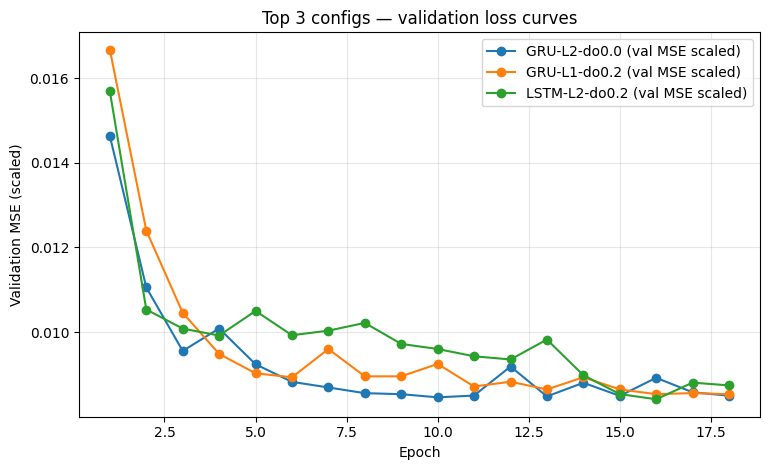

In [23]:
# --- Code: Overlay val-loss curves for top 2–3 configs ---
top_k = 3 if len(df_B_sorted) >= 3 else len(df_B_sorted)

best_labels = []
for i in range(top_k):
    r = df_B_sorted.iloc[i]
    best_labels.append(f"{r['Cell']}-L{int(r['Layers'])}-do{float(r['Dropout'])}")

import matplotlib.pyplot as plt
plt.figure(figsize=(7.8, 4.8))
for lab in best_labels:
    tr, va = curves_B[lab]
    plt.plot(range(1, len(va)+1), va, marker="o", label=f"{lab} (val MSE scaled)")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE (scaled)")
plt.title(f"Top {top_k} configs — validation loss curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**🧠 How we read the results**

- **Table (sorted by Val\_RMSE\_C):**  
  We scan the top rows: which cell **wins** under the chosen $S$? Does adding a **second layer** help? Does **dropout=0.2** reduce val error or just slow learning?

- **Curves (top-k val MSE):**  
  A good config shows **steady descent** and a **lower floor**. If a curve dips late but is noisy/unstable, we should be cautious.

**💬 Reflection — LSTM vs GRU after controlling depth/dropout**
- If **LSTM** wins here, we can argue its **cell state** helped carry information over the selected $S$.  
- If **GRU** wins (common on smaller datasets), we can argue it’s **lighter** (fewer parameters), easier to optimize, and sufficiently expressive for this task.  
- **Early overfit** pattern: train MSE ↓ while val MSE ↔/↑ (especially with 2 layers, no dropout). In that case, we prefer the **simpler** config or add a touch of **dropout**.

> Our selection criterion is **Val\_RMSE\_C** (tie-break by Val\_MAE\_C). We’ll carry the winner forward to the next section for a quick **generalization** check and a short **rollout** comparison.

---

#### **5. Select & Save + Takeaways**

We’ll wrap up NB04 by **saving the winner model**, **saving only its weights** (to keep artifacts light), and writing a tiny **config JSON** so we can rebuild the exact architecture next time.

> Why not save scalers or datasets? We prefer **code-driven reproducibility**. In future notebooks we will **rebuild the pipeline** and then load **just the weights** into the matching architecture.

In [25]:
# --- Code: Pick the winner (by Val_RMSE_C, tie-break by Val_MAE_C) and confirm BEST_S ---

import json
import os
import numpy as np
import pandas as pd
import torch

# 1) BEST_S from Experiment A (fall back to 7 if not found)
try:
    BEST_S = int(df_S.index[0])
except Exception:
    BEST_S = 7

# 2) Winner from Experiment B
assert "df_B_sorted" in globals() and not df_B_sorted.empty, "Please run Experiment B (Section 4) first."
best_row   = df_B_sorted.iloc[0]
best_cell  = str(best_row["Cell"])        # "GRU" or "LSTM"
best_layers  = int(best_row["Layers"])    # 1 or 2
best_dropout = float(best_row["Dropout"]) # 0.0 or 0.2
hidden_size  = 64                         # fixed in this notebook

print("=== Winner (validation) ===")
print({
    "Cell": best_cell,
    "Layers": best_layers,
    "Dropout": best_dropout,
    "Val_RMSE_C (°C)": round(float(best_row["Val_RMSE_C"]), 3),
    "Val_MAE_C (°C)":  round(float(best_row["Val_MAE_C"]),  3)
})
print(f"BEST_S selected in Exp A: {BEST_S}")

# For saving
save_dir = "artifacts"
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, "nb04_best.pkl")
config_path  = os.path.join(save_dir, "nb04_best_config.json")

=== Winner (validation) ===
{'Cell': 'GRU', 'Layers': 2, 'Dropout': 0.0, 'Val_RMSE_C (°C)': 2.425, 'Val_MAE_C (°C)': 1.895}
BEST_S selected in Exp A: 30


In [26]:
# --- Code: Save state_dict + tiny config ---

# Ensure we actually have a best model
assert "model_best" in globals() and model_best is not None, "Run Experiment B first to define model_best."

# Save weights
torch.save(model_best.state_dict(), weights_path)

# Save config
cfg = {
    "cell":   best_cell,
    "S":      int(BEST_S),
    "layers": int(best_layers),
    "dropout": float(best_dropout),
    "hidden": int(hidden_size),
    "batch_first": True
}
with open(config_path, "w") as f:
    json.dump(cfg, f, indent=2)

print(f"✅ Saved weights to: {weights_path}")
print(f"✅ Saved config  to: {config_path}")


✅ Saved weights to: artifacts\nb04_best.pkl
✅ Saved config  to: artifacts\nb04_best_config.json
